In [14]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [110]:
seed = 2013

In [111]:
from sklearn.model_selection import train_test_split
import smogn

df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.9,
                           k = 12,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.25,
                           k = 12,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.01,
                           k = 12,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 24/24 [00:00<00:00, 303.51it/s]


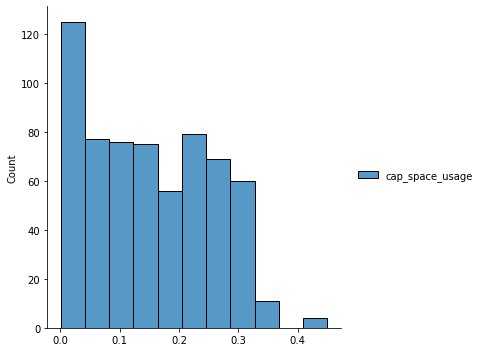

In [112]:
sns.displot(y)

In [113]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=20)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(20)['features'])

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [6]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

### Without train-validation-test split
**Since we have bootstrap in random forest, as it is based on the idea of bagging**, we can use oob_score as score for validation set and **save the trouble of using train-validation-test split.**

**Below is the experimentation**

In [114]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', 
                                  max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                  bootstrap=True, oob_score=True, n_jobs=-1, random_state=77, verbose=0, warm_start=False, 
                                  ccp_alpha=0.0, max_samples=None)
rf.fit(X[features], y)
evaluate(rf.predict(X[features]), y)

r^2:  0.9794027060968468
mse:  0.0002158346830080191
variance_score:  0.9795138167150013
mse-log:  0.0001677657740144732


In [115]:
rf.oob_score_

0.8418474319319832

In [116]:
evaluate(rf.predict(X_test[features]), y_test)

r^2:  0.8522740001625502
mse:  0.001288545794611515
variance_score:  0.8540598293881922
mse-log:  0.0010224541357116976


In [94]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 500, num = 25)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [i for i in range(1, 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [i for i in range(1, 10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [95]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(warm_start=True, bootstrap=True, oob_score=True) # use warm_start to speed up
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(oob_score=True,
                                                   warm_start=True),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 71, 91, 112,
                                                      132, 152, 173, 193, 214,
                                                      234, 255, 275, 295, 316,
                                                      336, 357, 377, 397, 418,
                                                      438, 459, 479, 500,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_spli

In [96]:
rf_random.best_params_

{'n_estimators': 385,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 152}

In [117]:
best = RandomForestRegressor(n_estimators=1200,
                                  max_depth=300, min_samples_split=3, min_samples_leaf=4, 
                                  max_features='log2', 
                                  bootstrap=True, oob_score=True, n_jobs=-1, random_state = 77)
best.fit(X[features], y)
evaluate(best.predict(X[features]), y)

r^2:  0.9318614626077856
mse:  0.0007140093105350709
variance_score:  0.9318982943762354
mse-log:  0.0005444144912763588


In [118]:
best.oob_score_

0.8447179291044224

In [119]:
evaluate(best.predict(X_test[features]), y_test)

r^2:  0.864966480160508
mse:  0.0011778351428470629
variance_score:  0.8683147573183492
mse-log:  0.0009337238210042328


In [120]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [121]:
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=best.predict(X_test[features]))], axis=1)

In [122]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
362,2019,Jabari Parker,26.9,11.897436,26.717949,1.4,1.662402,3694,0.059557,0.090249
274,2018,Raul Neto,12.1,3.682927,12.146341,0.9,0.416141,1201,0.021106,0.028328
232,2018,Wayne Ellington,26.5,9.090909,26.506494,4.5,2.589305,4309,0.061550,0.117628
373,2019,Brad Wanamaker,9.5,2.916667,9.527778,1.0,0.451722,775,0.013246,0.030220
107,2016,Thomas Robinson,12.9,4.098592,12.915493,0.6,0.655749,1879,0.011163,0.020414
23,2016,Trevor Booker,20.7,4.911392,20.658228,4.3,2.731892,3203,0.098255,0.067653
231,2018,Fred VanVleet,20.0,7.171053,20.000000,4.7,4.728443,3316,0.088349,0.083539
111,2016,Alan Anderson,14.8,4.538462,14.769231,0.3,0.339625,403,0.013973,0.047497
394,2019,Isaiah Thomas,15.1,8.250000,15.083333,-0.3,0.117090,403,0.021258,0.029988
124,2017,Jeff Teague,32.4,11.085366,32.402439,8.1,6.991121,5710,0.191739,0.229564
